# Generate VASP Inputs for Structure Relaxation

Note that all examples files are just valid vasprun.xml files and not necessary the actual outputs from a proper VASP calculation. They are presented just for code demonstration purposes.

In [1]:
# Uncomment the subsequent lines in this cell to install dependencies for Google Colab.
# !pip install pymatgen==2022.7.19


In [2]:
from pymatgen.core import Structure
from pymatgen.io.vasp.sets import MPRelaxSet
s = Structure.from_file("Al.cif", primitive=True)
custom_settings = {"NELMIN": 5}  # user custom incar settings
relax = MPRelaxSet(s, user_incar_settings=custom_settings)
relax.write_input("Al-relax")

/Users/shyue/repos/matgenb/.venv/lib/python3.11/site-packages/pymatgen/io/vasp/sets.py:722: BadInputSetWarning: Relaxation of likely metal with ISMEAR < 0 (-5). See VASP recommendations on ISMEAR for metals (https://www.vasp.at/wiki/index.php/ISMEAR).
  warnings.warn(


## Get total energy and relaxed structure

In [3]:
from pymatgen.io.vasp import Vasprun

v = Vasprun("Al-relax/vasprun.xml.gz")
print(v.final_energy)  # final total energy
s = v.final_structure
s.to(fmt="cif")  # save relaxed structure into cif file
print(s)  # relaxed structure

-3.74198121 eV
Full Formula (Al1)
Reduced Formula: Al
abc   :   2.857496   2.857496   2.857496
angles:  60.000000  60.000000  60.000000
pbc   :       True       True       True
Sites (1)
  #  SP      a    b    c
---  ----  ---  ---  ---
  0  Al      0    0    0


# Generate VASP Input for Static Run

In [4]:
from pymatgen.io.vasp.sets import MPStaticSet

custom_settings = {"NELM": 60}  # user custom incar settings
static = MPStaticSet.from_prev_calc(
    "Al-relax/", standardize=True, user_incar_settings=custom_settings
)
static.write_input("Al-static")

/Users/shyue/repos/matgenb/.venv/lib/python3.11/site-packages/pymatgen/io/vasp/sets.py:999: UserWarning: Use of standardize=True with from_prev_run is not recommended as there is no guarantee the copied files will be appropriate for the standardized structure.
  warnings.warn(


## Get total energy from static run

In [5]:
from pymatgen.io.vasp import Vasprun

v = Vasprun("Al-static/vasprun.xml.gz")
print(v.final_energy)  # final total energy

-3.74198121 eV


# Generate VASP Input for Density of State(DOS) and Band Structure(BS) calculation

In [6]:
from pymatgen.io.vasp.sets import MPNonSCFSet

# generate uniform k-points for DOS calc.
custom_settings = {"LAECHG": "False", "LVHAR": "False"}  # user custom incar settings
dos = MPNonSCFSet.from_prev_calc(
    "Al-static/",
    mode="uniform",
    reciprocal_density=200,
    user_incar_settings=custom_settings,
)
dos.write_input("Al-dos")

# generate k-points along high symmetry line for band structure calc.
band = MPNonSCFSet.from_prev_calc(
    "Al-static/", mode="line", standardize=True, user_incar_settings=custom_settings
)
band.write_input("Al-band")

/Users/shyue/repos/matgenb/.venv/lib/python3.11/site-packages/pymatgen/io/vasp/sets.py:1713: UserWarning: Use of standardize=True with from_prev_run is not recommended as there is no guarantee the copied files will be appropriate for the standardized structure. copy_chgcar is enforced to be false.
  warnings.warn(


## Plot Total DOS

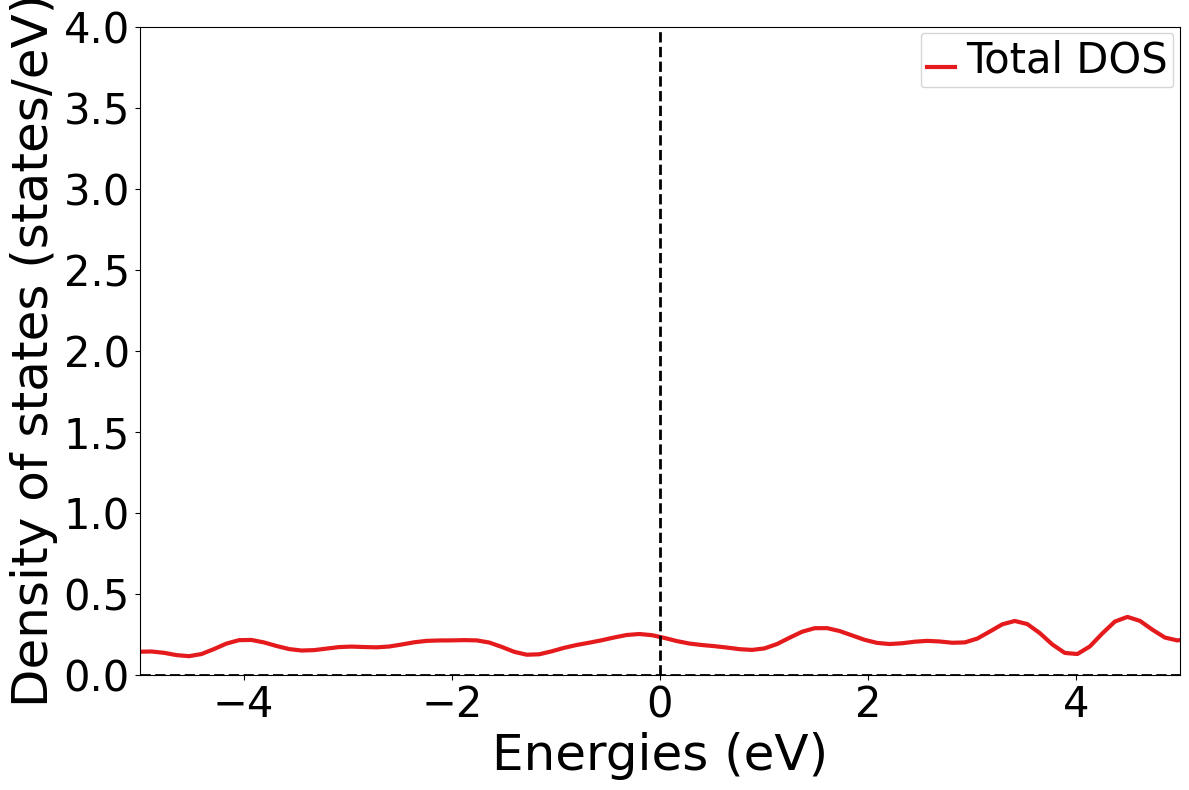

In [7]:
%matplotlib inline
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.io.vasp import Vasprun

v = Vasprun("Al-dos/vasprun.xml.gz")
tdos = v.tdos
plotter = DosPlotter()
plotter.add_dos("Total DOS", tdos)
plotter.show(xlim=[-5, 5], ylim=[0, 4])

## Plot element-projected DOS

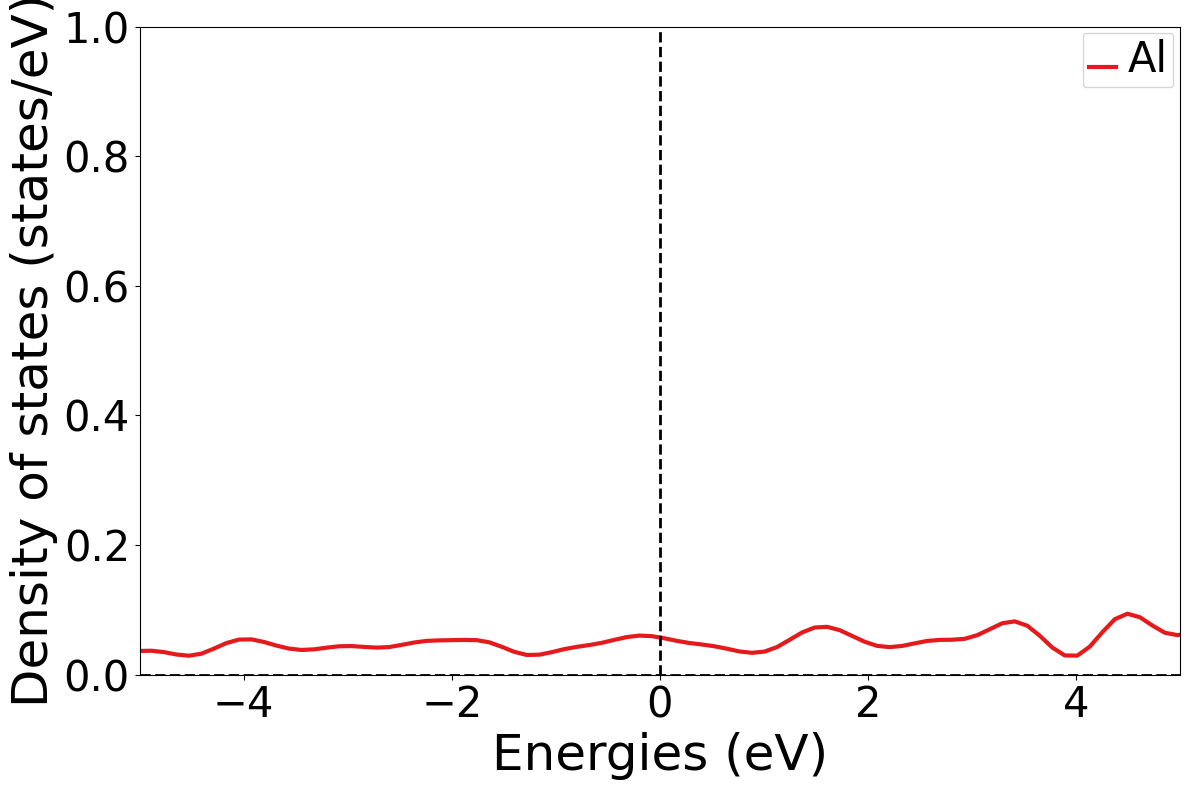

In [8]:
%matplotlib inline
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.io.vasp import Vasprun

v = Vasprun("Al-dos/vasprun.xml.gz")
cdos = v.complete_dos
element_dos = cdos.get_element_dos()
plotter = DosPlotter()
plotter.add_dos_dict(element_dos)
plotter.show(xlim=[-5, 5], ylim=[0, 1])

## Plot orbital-projected DOS

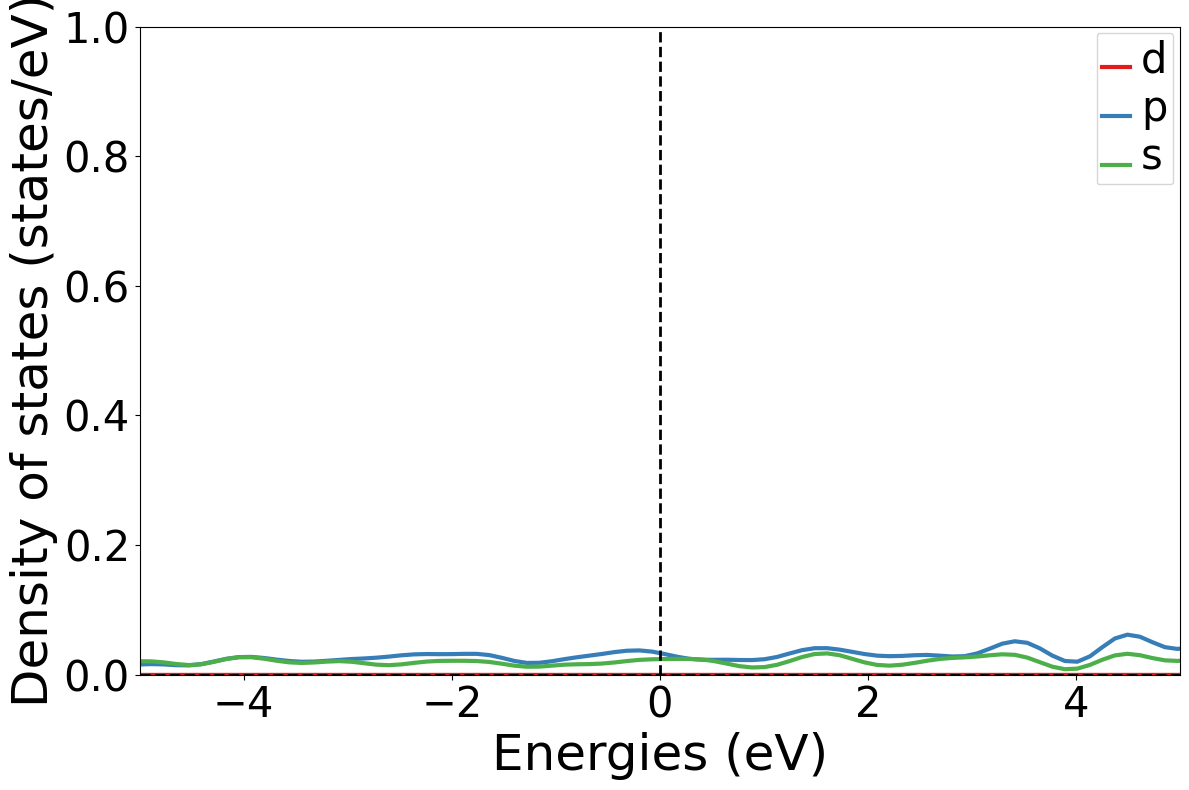

In [9]:
%matplotlib inline
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.io.vasp import Vasprun

v = Vasprun("Al-dos/vasprun.xml.gz")
cdos = v.complete_dos
spd_dos = cdos.get_spd_dos()
plotter = DosPlotter()
plotter.add_dos_dict(spd_dos)
plotter.show(xlim=[-5, 5], ylim=[0, 1])

# Plot BS

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{E\\ -\\ E_f\\ (eV)}$'>

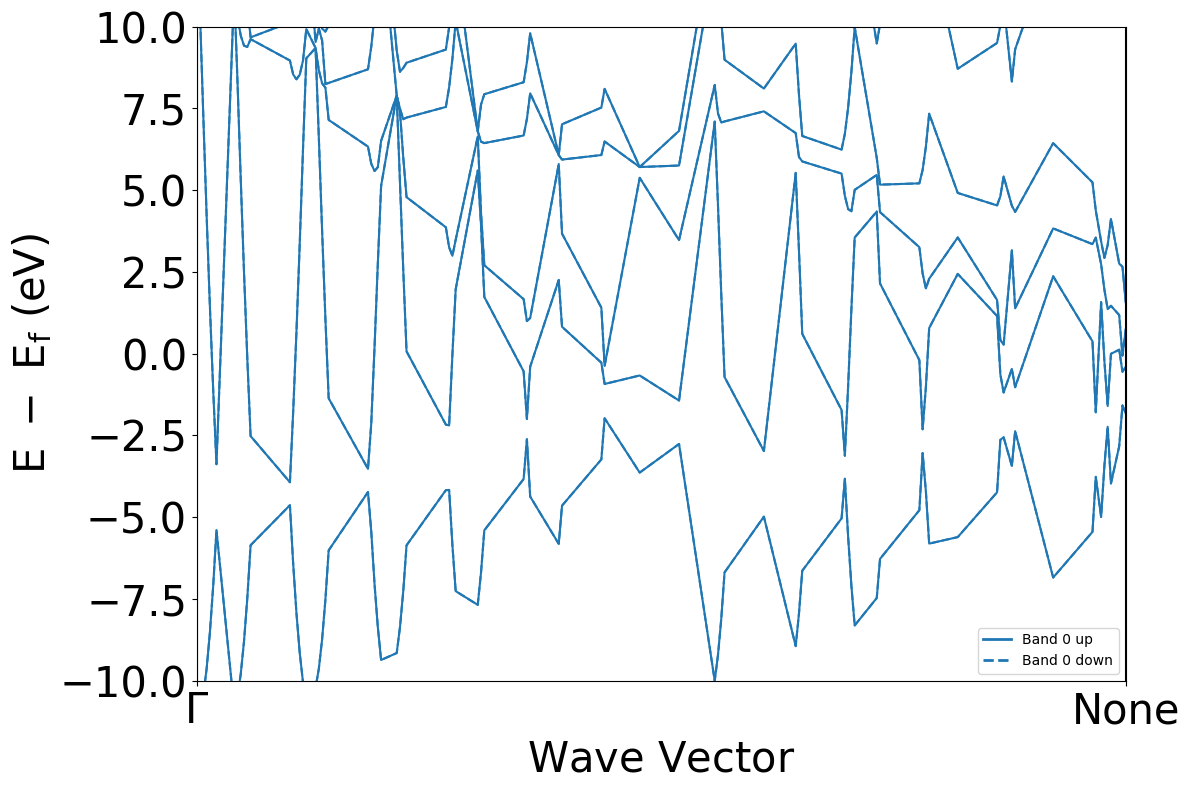

In [10]:
%matplotlib inline
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.io.vasp import BSVasprun, Vasprun

v = BSVasprun("Al-band/vasprun.xml.gz")
bs = v.get_band_structure(kpoints_filename="Al-band/KPOINTS", line_mode=True)
plt = BSPlotter(bs)
plt.get_plot(vbm_cbm_marker=True)